In [1]:
#IS Notebook Training Mopdel Without EDA Part
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time
import datetime
import warnings
warnings.filterwarnings("ignore")


In [2]:
df=pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv")


In [3]:
print('Null value in dataframe :', sum(df.Weighted_Price.isnull()))

Null value in dataframe : 1214307


### Preparing data for feeding the models

In [4]:
# Split this into train/test set -  1 Jan 2016 to   30 Sep 2018 
date_first = "1/1/2016"
date_last = "30/9/2018"
time_first = time.mktime(datetime.datetime.strptime(date_first, "%d/%m/%Y").timetuple())
time_last = time.mktime(datetime.datetime.strptime(date_last, "%d/%m/%Y").timetuple())

In [5]:
time_first

1451581200.0

In [6]:
time_last

1538240400.0

In [7]:
df = df.drop(df[(df.Timestamp < time_first) | (df.Timestamp > time_last)].index) #Drop outside masking

In [8]:
df = df[np.isfinite(df['Weighted_Price'])] #drop NaN

In [9]:
df.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
3542232,1538240160,6529.87,6534.16,6529.87,6534.16,0.814962,5322.642785,6531.155044
3542233,1538240220,6531.62,6535.12,6531.62,6535.12,0.341810,2232.902277,6532.584387
3542234,1538240280,6533.74,6534.67,6531.62,6534.67,0.843771,5512.049066,6532.635606
3542235,1538240340,6529.84,6533.32,6529.73,6533.32,1.952942,12752.290488,6529.783809
3542236,1538240400,6529.82,6533.35,6529.82,6529.82,0.467519,3053.033251,6530.282398


In [10]:
df["date"]=pd.to_datetime(df["Timestamp"],unit="s").dt.date
group=df.groupby("date")
data=group["Weighted_Price"].mean()

In [11]:
data.shape

(1004,)

In [12]:
data.isnull().sum() # Recheck

0

In [13]:
data.head()

date
2015-12-31    431.076827
2016-01-01    432.762815
2016-01-02    433.102496
2016-01-03    429.069676
2016-01-04    432.434197
Name: Weighted_Price, dtype: float64

The goal is making a prediction of daily close datas.

In [14]:
price_train=data.iloc[:len(data)-30] #Train set - 30 latest days
price_test=data.iloc[len(price_train):]

In [15]:
np.array(price_train).shape

(974,)

### feature scalling (set values between 0-1)

In [16]:

price_train=np.array(price_train)
price_train=price_train.reshape(price_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
price_scaled=scaler.fit_transform(price_train)

### Set timestep

In [17]:
timestep=30 # Timestep (Days)
x_train=[]
y_train=[]

for i in range(timestep,price_scaled.shape[0]):
    x_train.append(price_scaled[i-timestep:i,0])
    y_train.append(price_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (944, 30, 1)
y_train shape=  (944,)


### RNN Model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten


start = time.time()
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))

#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error", metrics=[r_square, rmse])
regressor.fit(x_train,y_train,epochs=400,batch_size=100)

end = time.time()
print("RNN Total application takes time to process: " + str(end-start))

Using TensorFlow backend.


Epoch 1/400
944/944 [==============================] - 2s 2ms/step - loss: 0.0230 - r_square: 0.4718 - rmse: 0.0809
Epoch 2/400
944/944 [==============================] - 2s 2ms/step - loss: 0.0042 - r_square: 0.9155 - rmse: 0.0357
Epoch 3/400
944/944 [==============================] - 2s 2ms/step - loss: 0.0036 - r_square: 0.9232 - rmse: 0.0329
Epoch 4/400
944/944 [==============================] - 2s 2ms/step - loss: 0.0026 - r_square: 0.9454 - rmse: 0.0275
Epoch 5/400
944/944 [==============================] - 1s 2ms/step - loss: 0.0019 - r_square: 0.9580 - rmse: 0.0228
Epoch 6/400
944/944 [==============================] - 1s 2ms/step - loss: 0.0015 - r_square: 0.9673 - rmse: 0.0207
Epoch 7/400
944/944 [==============================] - 1s 2ms/step - loss: 0.0016 - r_square: 0.9659 - rmse: 0.0220
Epoch 8/400
944/944 [==============================] - 1s 1ms/step - loss: 0.0015 - r_square: 0.9688 - rmse: 0.0210
Epoch 9/400
944/944 [==============================] - 1s 1ms/step - los

944/944 [==============================] - 1s 2ms/step - loss: 4.9751e-04 - r_square: 0.9893 - rmse: 0.0127
Epoch 70/400
944/944 [==============================] - 2s 2ms/step - loss: 4.8851e-04 - r_square: 0.9895 - rmse: 0.0127
Epoch 71/400
944/944 [==============================] - 2s 2ms/step - loss: 5.0375e-04 - r_square: 0.9893 - rmse: 0.0128
Epoch 72/400
944/944 [==============================] - 2s 2ms/step - loss: 5.4127e-04 - r_square: 0.9883 - rmse: 0.0134
Epoch 73/400
944/944 [==============================] - 2s 2ms/step - loss: 4.0195e-04 - r_square: 0.9914 - rmse: 0.0116
Epoch 74/400
944/944 [==============================] - 2s 2ms/step - loss: 3.8064e-04 - r_square: 0.9919 - rmse: 0.0108
Epoch 75/400
944/944 [==============================] - 2s 2ms/step - loss: 4.2023e-04 - r_square: 0.9911 - rmse: 0.0114
Epoch 76/400
944/944 [==============================] - 2s 2ms/step - loss: 4.1512e-04 - r_square: 0.9910 - rmse: 0.0115
Epoch 77/400
944/944 [=======================

944/944 [==============================] - 1s 2ms/step - loss: 3.8770e-04 - r_square: 0.9917 - rmse: 0.0114
Epoch 137/400
944/944 [==============================] - 1s 2ms/step - loss: 3.6269e-04 - r_square: 0.9921 - rmse: 0.0105
Epoch 138/400
944/944 [==============================] - 1s 1ms/step - loss: 3.1251e-04 - r_square: 0.9933 - rmse: 0.0106
Epoch 139/400
944/944 [==============================] - 1s 2ms/step - loss: 3.6574e-04 - r_square: 0.9920 - rmse: 0.0106
Epoch 140/400
944/944 [==============================] - 2s 2ms/step - loss: 3.0404e-04 - r_square: 0.9933 - rmse: 0.0104
Epoch 141/400
944/944 [==============================] - 2s 2ms/step - loss: 3.8448e-04 - r_square: 0.9918 - rmse: 0.0119
Epoch 142/400
944/944 [==============================] - 1s 2ms/step - loss: 3.2013e-04 - r_square: 0.9930 - rmse: 0.0105
Epoch 143/400
944/944 [==============================] - 1s 2ms/step - loss: 2.9480e-04 - r_square: 0.9937 - rmse: 0.0098
Epoch 144/400
944/944 [===============

944/944 [==============================] - 1s 2ms/step - loss: 2.8768e-04 - r_square: 0.9939 - rmse: 0.0102
Epoch 204/400
944/944 [==============================] - 2s 2ms/step - loss: 2.3313e-04 - r_square: 0.9949 - rmse: 0.0092
Epoch 205/400
944/944 [==============================] - 1s 2ms/step - loss: 3.2882e-04 - r_square: 0.9930 - rmse: 0.0103
Epoch 206/400
944/944 [==============================] - 1s 2ms/step - loss: 2.4587e-04 - r_square: 0.9947 - rmse: 0.0095
Epoch 207/400
944/944 [==============================] - 1s 2ms/step - loss: 2.7184e-04 - r_square: 0.9942 - rmse: 0.0096
Epoch 208/400
944/944 [==============================] - 2s 2ms/step - loss: 2.5032e-04 - r_square: 0.9948 - rmse: 0.0093
Epoch 209/400
944/944 [==============================] - 1s 2ms/step - loss: 2.5232e-04 - r_square: 0.9947 - rmse: 0.0091
Epoch 210/400
944/944 [==============================] - 1s 2ms/step - loss: 2.6852e-04 - r_square: 0.9943 - rmse: 0.0096
Epoch 211/400
944/944 [===============

944/944 [==============================] - 2s 2ms/step - loss: 3.3690e-04 - r_square: 0.9929 - rmse: 0.0102
Epoch 271/400
944/944 [==============================] - 1s 1ms/step - loss: 3.6354e-04 - r_square: 0.9922 - rmse: 0.0111
Epoch 272/400
944/944 [==============================] - 1s 1ms/step - loss: 2.8578e-04 - r_square: 0.9940 - rmse: 0.0096
Epoch 273/400
944/944 [==============================] - 1s 2ms/step - loss: 2.5732e-04 - r_square: 0.9945 - rmse: 0.0093
Epoch 274/400
944/944 [==============================] - 1s 1ms/step - loss: 2.6175e-04 - r_square: 0.9944 - rmse: 0.0090
Epoch 275/400
944/944 [==============================] - 1s 1ms/step - loss: 2.2496e-04 - r_square: 0.9953 - rmse: 0.0087
Epoch 276/400
944/944 [==============================] - 1s 1ms/step - loss: 2.2838e-04 - r_square: 0.9951 - rmse: 0.0093
Epoch 277/400
944/944 [==============================] - 1s 1ms/step - loss: 2.5947e-04 - r_square: 0.9946 - rmse: 0.0097
Epoch 278/400
944/944 [===============

944/944 [==============================] - 2s 2ms/step - loss: 2.1359e-04 - r_square: 0.9955 - rmse: 0.0087
Epoch 338/400
944/944 [==============================] - 2s 2ms/step - loss: 2.0142e-04 - r_square: 0.9957 - rmse: 0.0086
Epoch 339/400
944/944 [==============================] - 1s 1ms/step - loss: 2.5058e-04 - r_square: 0.9946 - rmse: 0.0090
Epoch 340/400
944/944 [==============================] - 1s 1ms/step - loss: 1.8764e-04 - r_square: 0.9960 - rmse: 0.0081
Epoch 341/400
944/944 [==============================] - 1s 1ms/step - loss: 2.7485e-04 - r_square: 0.9943 - rmse: 0.0090
Epoch 342/400
944/944 [==============================] - 1s 1ms/step - loss: 2.1080e-04 - r_square: 0.9955 - rmse: 0.0083
Epoch 343/400
944/944 [==============================] - 1s 1ms/step - loss: 2.3085e-04 - r_square: 0.9950 - rmse: 0.0090
Epoch 344/400
944/944 [==============================] - 1s 1ms/step - loss: 1.8740e-04 - r_square: 0.9959 - rmse: 0.0087
Epoch 345/400
944/944 [===============

In [19]:
inputs=data[len(data)-len(price_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [20]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [21]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

### RNN Visualize

In [22]:
data_test=np.array(price_test)
data_test=data_test.reshape(len(data_test),1)

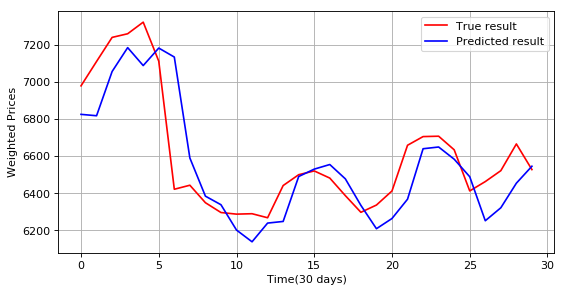

In [23]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="True result")
plt.plot(predicted_data,color="b",label="Predicted result")
plt.legend()
plt.xlabel("Time(30 days)")
plt.ylabel("Weighted Prices")
plt.grid(True)
plt.show()

### GRU Model

In [24]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten, GRU

start = time.time()
model=Sequential()

model.add(GRU(256,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam", metrics=[r_square, rmse])

model.fit(x_train,y_train,epochs=400,batch_size=100)

end = time.time()
print("GRU Total application takes time to process: " + str(end-start))

Epoch 1/400
944/944 [==============================] - 1s 939us/step - loss: 0.0303 - r_square: 0.3625 - rmse: 0.1080
Epoch 2/400
944/944 [==============================] - 0s 459us/step - loss: 0.0033 - r_square: 0.9252 - rmse: 0.0485
Epoch 3/400
944/944 [==============================] - 0s 467us/step - loss: 0.0011 - r_square: 0.9756 - rmse: 0.0188
Epoch 4/400
944/944 [==============================] - 0s 453us/step - loss: 7.1725e-04 - r_square: 0.9841 - rmse: 0.0187
Epoch 5/400
944/944 [==============================] - 0s 462us/step - loss: 5.3686e-04 - r_square: 0.9885 - rmse: 0.0130
Epoch 6/400
944/944 [==============================] - 0s 438us/step - loss: 5.0752e-04 - r_square: 0.9894 - rmse: 0.0131
Epoch 7/400
944/944 [==============================] - 0s 451us/step - loss: 5.0199e-04 - r_square: 0.9893 - rmse: 0.0119
Epoch 8/400
944/944 [==============================] - 0s 442us/step - loss: 5.3118e-04 - r_square: 0.9883 - rmse: 0.0131
Epoch 9/400
944/944 [===============

944/944 [==============================] - 0s 481us/step - loss: 2.6258e-04 - r_square: 0.9944 - rmse: 0.0079
Epoch 68/400
944/944 [==============================] - 0s 490us/step - loss: 2.6450e-04 - r_square: 0.9944 - rmse: 0.0080
Epoch 69/400
944/944 [==============================] - 0s 457us/step - loss: 2.6681e-04 - r_square: 0.9942 - rmse: 0.0083
Epoch 70/400
944/944 [==============================] - 0s 467us/step - loss: 2.7528e-04 - r_square: 0.9941 - rmse: 0.0088
Epoch 71/400
944/944 [==============================] - 0s 479us/step - loss: 2.6452e-04 - r_square: 0.9943 - rmse: 0.0085
Epoch 72/400
944/944 [==============================] - 0s 515us/step - loss: 2.9210e-04 - r_square: 0.9939 - rmse: 0.0096
Epoch 73/400
944/944 [==============================] - 0s 486us/step - loss: 2.6687e-04 - r_square: 0.9943 - rmse: 0.0089
Epoch 74/400
944/944 [==============================] - 0s 483us/step - loss: 2.6021e-04 - r_square: 0.9943 - rmse: 0.0081
Epoch 75/400
944/944 [=======

944/944 [==============================] - 0s 448us/step - loss: 2.6684e-04 - r_square: 0.9943 - rmse: 0.0093
Epoch 134/400
944/944 [==============================] - 0s 449us/step - loss: 2.2623e-04 - r_square: 0.9952 - rmse: 0.0077
Epoch 135/400
944/944 [==============================] - 0s 465us/step - loss: 2.4623e-04 - r_square: 0.9948 - rmse: 0.0089
Epoch 136/400
944/944 [==============================] - 0s 447us/step - loss: 2.3390e-04 - r_square: 0.9951 - rmse: 0.0080
Epoch 137/400
944/944 [==============================] - 0s 464us/step - loss: 2.4046e-04 - r_square: 0.9949 - rmse: 0.0078
Epoch 138/400
944/944 [==============================] - 0s 446us/step - loss: 2.2494e-04 - r_square: 0.9953 - rmse: 0.0074
Epoch 139/400
944/944 [==============================] - 0s 464us/step - loss: 2.3692e-04 - r_square: 0.9950 - rmse: 0.0076
Epoch 140/400
944/944 [==============================] - 0s 436us/step - loss: 2.6054e-04 - r_square: 0.9945 - rmse: 0.0091
Epoch 141/400
944/944 

944/944 [==============================] - 0s 472us/step - loss: 2.3587e-04 - r_square: 0.9951 - rmse: 0.0084
Epoch 199/400
944/944 [==============================] - 0s 461us/step - loss: 2.5044e-04 - r_square: 0.9948 - rmse: 0.0085
Epoch 200/400
944/944 [==============================] - 0s 461us/step - loss: 2.3600e-04 - r_square: 0.9950 - rmse: 0.0079
Epoch 201/400
944/944 [==============================] - 0s 463us/step - loss: 2.4467e-04 - r_square: 0.9949 - rmse: 0.0088
Epoch 202/400
944/944 [==============================] - 0s 446us/step - loss: 2.4127e-04 - r_square: 0.9949 - rmse: 0.0088
Epoch 203/400
944/944 [==============================] - 0s 442us/step - loss: 2.2120e-04 - r_square: 0.9954 - rmse: 0.0075
Epoch 204/400
944/944 [==============================] - 0s 428us/step - loss: 2.1670e-04 - r_square: 0.9953 - rmse: 0.0075
Epoch 205/400
944/944 [==============================] - 0s 481us/step - loss: 2.2218e-04 - r_square: 0.9952 - rmse: 0.0077
Epoch 206/400
944/944 

944/944 [==============================] - 0s 446us/step - loss: 2.1819e-04 - r_square: 0.9952 - rmse: 0.0079
Epoch 265/400
944/944 [==============================] - 0s 432us/step - loss: 2.2434e-04 - r_square: 0.9953 - rmse: 0.0072
Epoch 266/400
944/944 [==============================] - 0s 442us/step - loss: 2.3012e-04 - r_square: 0.9950 - rmse: 0.0079
Epoch 267/400
944/944 [==============================] - 0s 456us/step - loss: 2.5673e-04 - r_square: 0.9945 - rmse: 0.0093
Epoch 268/400
944/944 [==============================] - 0s 436us/step - loss: 2.4064e-04 - r_square: 0.9949 - rmse: 0.0090
Epoch 269/400
944/944 [==============================] - 0s 451us/step - loss: 2.2604e-04 - r_square: 0.9953 - rmse: 0.0078
Epoch 270/400
944/944 [==============================] - 0s 470us/step - loss: 2.4044e-04 - r_square: 0.9949 - rmse: 0.0082
Epoch 271/400
944/944 [==============================] - 0s 492us/step - loss: 2.3202e-04 - r_square: 0.9950 - rmse: 0.0077
Epoch 272/400
944/944 

944/944 [==============================] - 0s 450us/step - loss: 2.2433e-04 - r_square: 0.9952 - rmse: 0.0082
Epoch 331/400
944/944 [==============================] - 0s 463us/step - loss: 2.2591e-04 - r_square: 0.9952 - rmse: 0.0082
Epoch 332/400
944/944 [==============================] - 0s 439us/step - loss: 2.4143e-04 - r_square: 0.9950 - rmse: 0.0085
Epoch 333/400
944/944 [==============================] - 0s 448us/step - loss: 2.8396e-04 - r_square: 0.9940 - rmse: 0.0104
Epoch 334/400
944/944 [==============================] - 0s 447us/step - loss: 2.5224e-04 - r_square: 0.9945 - rmse: 0.0096
Epoch 335/400
944/944 [==============================] - 0s 469us/step - loss: 2.4888e-04 - r_square: 0.9944 - rmse: 0.0086
Epoch 336/400
944/944 [==============================] - 0s 451us/step - loss: 2.3161e-04 - r_square: 0.9950 - rmse: 0.0076
Epoch 337/400
944/944 [==============================] - 0s 447us/step - loss: 2.1105e-04 - r_square: 0.9954 - rmse: 0.0070
Epoch 338/400
944/944 

944/944 [==============================] - 0s 492us/step - loss: 2.1795e-04 - r_square: 0.9954 - rmse: 0.0076
Epoch 397/400
944/944 [==============================] - 0s 472us/step - loss: 2.1476e-04 - r_square: 0.9954 - rmse: 0.0072
Epoch 398/400
944/944 [==============================] - 0s 511us/step - loss: 2.0723e-04 - r_square: 0.9956 - rmse: 0.0068
Epoch 399/400
944/944 [==============================] - 0s 478us/step - loss: 2.1429e-04 - r_square: 0.9953 - rmse: 0.0074
Epoch 400/400
944/944 [==============================] - 0s 497us/step - loss: 2.1934e-04 - r_square: 0.9954 - rmse: 0.0079
GRU Total application takes time to process: 174.6786766052246


In [25]:
inputs=data[len(data)-len(price_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [26]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [27]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [28]:
data_test=np.array(price_test)
data_test=data_test.reshape(len(data_test),1)

### GRU Visualize

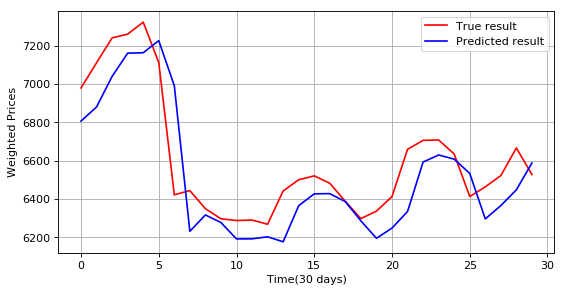

In [29]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="True result")
plt.plot(predicted_data,color="b",label="Predicted result")
plt.legend()
plt.xlabel("Time(30 days)")
plt.ylabel("Weighted Prices")
plt.grid(True)
plt.show()

### LSTM Model

In [30]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

start = time.time()
model=Sequential()

model.add(LSTM(512,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam", metrics=[r_square, rmse])

model.fit(x_train,y_train,epochs=400,batch_size=100)

end = time.time()
print("LSTM Total application takes time to process: " + str(end-start))

Epoch 1/400
944/944 [==============================] - 3s 3ms/step - loss: 0.0344 - r_square: 0.2993 - rmse: 0.1231
Epoch 2/400
944/944 [==============================] - 2s 3ms/step - loss: 0.0071 - r_square: 0.8436 - rmse: 0.0598
Epoch 3/400
944/944 [==============================] - 2s 3ms/step - loss: 0.0021 - r_square: 0.9549 - rmse: 0.0266
Epoch 4/400
944/944 [==============================] - 2s 3ms/step - loss: 0.0015 - r_square: 0.9678 - rmse: 0.0195
Epoch 5/400
944/944 [==============================] - 2s 2ms/step - loss: 0.0016 - r_square: 0.9656 - rmse: 0.0227
Epoch 6/400
944/944 [==============================] - 2s 3ms/step - loss: 0.0013 - r_square: 0.9717 - rmse: 0.0189
Epoch 7/400
944/944 [==============================] - 2s 2ms/step - loss: 0.0013 - r_square: 0.9727 - rmse: 0.0178
Epoch 8/400
944/944 [==============================] - 2s 3ms/step - loss: 0.0012 - r_square: 0.9749 - rmse: 0.0171
Epoch 9/400
944/944 [==============================] - 2s 3ms/step - los

944/944 [==============================] - 2s 3ms/step - loss: 5.6464e-04 - r_square: 0.9881 - rmse: 0.0137
Epoch 70/400
944/944 [==============================] - 2s 3ms/step - loss: 5.5287e-04 - r_square: 0.9883 - rmse: 0.0125
Epoch 71/400
944/944 [==============================] - 2s 2ms/step - loss: 5.2617e-04 - r_square: 0.9887 - rmse: 0.0123
Epoch 72/400
944/944 [==============================] - 2s 2ms/step - loss: 5.2069e-04 - r_square: 0.9887 - rmse: 0.0129
Epoch 73/400
944/944 [==============================] - 2s 2ms/step - loss: 4.8462e-04 - r_square: 0.9899 - rmse: 0.0120
Epoch 74/400
944/944 [==============================] - 2s 3ms/step - loss: 4.5499e-04 - r_square: 0.9905 - rmse: 0.0110
Epoch 75/400
944/944 [==============================] - 2s 3ms/step - loss: 4.5243e-04 - r_square: 0.9905 - rmse: 0.0110
Epoch 76/400
944/944 [==============================] - 2s 3ms/step - loss: 4.4186e-04 - r_square: 0.9908 - rmse: 0.0104
Epoch 77/400
944/944 [=======================

944/944 [==============================] - 2s 3ms/step - loss: 3.7931e-04 - r_square: 0.9919 - rmse: 0.0102
Epoch 137/400
944/944 [==============================] - 2s 3ms/step - loss: 3.7385e-04 - r_square: 0.9919 - rmse: 0.0114
Epoch 138/400
944/944 [==============================] - 2s 2ms/step - loss: 3.0978e-04 - r_square: 0.9933 - rmse: 0.0097
Epoch 139/400
944/944 [==============================] - 2s 2ms/step - loss: 2.9208e-04 - r_square: 0.9938 - rmse: 0.0088
Epoch 140/400
944/944 [==============================] - 2s 3ms/step - loss: 2.7029e-04 - r_square: 0.9942 - rmse: 0.0083
Epoch 141/400
944/944 [==============================] - 2s 3ms/step - loss: 2.5692e-04 - r_square: 0.9943 - rmse: 0.0082
Epoch 142/400
944/944 [==============================] - 2s 3ms/step - loss: 2.8518e-04 - r_square: 0.9940 - rmse: 0.0091
Epoch 143/400
944/944 [==============================] - 2s 3ms/step - loss: 2.7542e-04 - r_square: 0.9940 - rmse: 0.0092
Epoch 144/400
944/944 [===============

944/944 [==============================] - 2s 3ms/step - loss: 2.1327e-04 - r_square: 0.9953 - rmse: 0.0079
Epoch 203/400
944/944 [==============================] - 2s 2ms/step - loss: 2.2026e-04 - r_square: 0.9952 - rmse: 0.0083
Epoch 204/400
944/944 [==============================] - 2s 2ms/step - loss: 2.0435e-04 - r_square: 0.9957 - rmse: 0.0076
Epoch 205/400
944/944 [==============================] - 2s 2ms/step - loss: 2.5569e-04 - r_square: 0.9945 - rmse: 0.0090
Epoch 206/400
944/944 [==============================] - 2s 2ms/step - loss: 2.7199e-04 - r_square: 0.9943 - rmse: 0.0093
Epoch 207/400
944/944 [==============================] - 2s 3ms/step - loss: 2.2811e-04 - r_square: 0.9952 - rmse: 0.0086
Epoch 208/400
944/944 [==============================] - 2s 2ms/step - loss: 2.1323e-04 - r_square: 0.9954 - rmse: 0.0088
Epoch 209/400
944/944 [==============================] - 2s 2ms/step - loss: 2.2828e-04 - r_square: 0.9951 - rmse: 0.0083
Epoch 210/400
944/944 [===============

944/944 [==============================] - 2s 3ms/step - loss: 2.1632e-04 - r_square: 0.9954 - rmse: 0.0087
Epoch 270/400
944/944 [==============================] - 2s 3ms/step - loss: 1.9644e-04 - r_square: 0.9958 - rmse: 0.0081
Epoch 271/400
944/944 [==============================] - 3s 3ms/step - loss: 1.9005e-04 - r_square: 0.9960 - rmse: 0.0076
Epoch 272/400
944/944 [==============================] - 2s 2ms/step - loss: 2.3073e-04 - r_square: 0.9950 - rmse: 0.0090
Epoch 273/400
944/944 [==============================] - 2s 2ms/step - loss: 2.0655e-04 - r_square: 0.9955 - rmse: 0.0076
Epoch 274/400
944/944 [==============================] - 2s 2ms/step - loss: 1.9487e-04 - r_square: 0.9958 - rmse: 0.0081
Epoch 275/400
944/944 [==============================] - 2s 2ms/step - loss: 1.8275e-04 - r_square: 0.9960 - rmse: 0.0076
Epoch 276/400
944/944 [==============================] - 2s 2ms/step - loss: 1.9098e-04 - r_square: 0.9959 - rmse: 0.0077
Epoch 277/400
944/944 [===============

944/944 [==============================] - 2s 2ms/step - loss: 2.0081e-04 - r_square: 0.9958 - rmse: 0.0089
Epoch 337/400
944/944 [==============================] - 2s 2ms/step - loss: 2.0323e-04 - r_square: 0.9956 - rmse: 0.0081
Epoch 338/400
944/944 [==============================] - 2s 2ms/step - loss: 2.0134e-04 - r_square: 0.9957 - rmse: 0.0083
Epoch 339/400
944/944 [==============================] - 2s 2ms/step - loss: 1.8071e-04 - r_square: 0.9961 - rmse: 0.0073
Epoch 340/400
944/944 [==============================] - 2s 2ms/step - loss: 1.5833e-04 - r_square: 0.9967 - rmse: 0.0071
Epoch 341/400
944/944 [==============================] - 2s 2ms/step - loss: 1.5877e-04 - r_square: 0.9966 - rmse: 0.0072
Epoch 342/400
944/944 [==============================] - 2s 2ms/step - loss: 1.6588e-04 - r_square: 0.9965 - rmse: 0.0075
Epoch 343/400
944/944 [==============================] - 2s 2ms/step - loss: 1.5241e-04 - r_square: 0.9967 - rmse: 0.0066
Epoch 344/400
944/944 [===============

In [31]:
inputs=data[len(data)-len(price_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [32]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [33]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [34]:
data_test=np.array(price_test)
data_test=data_test.reshape(len(data_test),1)

### LSTM Visualize

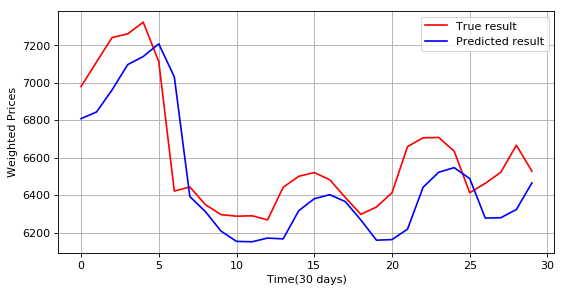

In [35]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="True result")
plt.plot(predicted_data,color="b",label="Predicted result")
plt.legend()
plt.xlabel("Time(30 days)")
plt.ylabel("Weighted Prices")
plt.grid(True)
plt.show()

In [36]:
predicted_data

array([[6807.7324],
       [6843.739 ],
       [6961.647 ],
       [7096.072 ],
       [7139.5156],
       [7207.146 ],
       [7030.9053],
       [6391.977 ],
       [6311.885 ],
       [6208.156 ],
       [6152.856 ],
       [6150.6553],
       [6170.582 ],
       [6166.081 ],
       [6316.284 ],
       [6380.4556],
       [6402.049 ],
       [6365.0674],
       [6266.819 ],
       [6159.309 ],
       [6162.3975],
       [6218.39  ],
       [6441.552 ],
       [6521.6387],
       [6546.4985],
       [6488.017 ],
       [6277.2344],
       [6279.17  ],
       [6322.9604],
       [6464.9434]], dtype=float32)